In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import multiprocessing as mp
import pandas as pd
import numpy as np
from functools import partial
import random

from helper_functions import *

In [2]:
%%time
if __name__ == '__main__':
    HORIZON = 8
    WINDOW_SIZE = 8

    train = pd.read_csv('train.csv')
    IDS = train.cfips.unique()

    x_train = np.arange(39).reshape((-1,1))
    x_test = np.arange(31,39).reshape((-1,1))
    random_ids = random.sample(list(IDS), 10)
    window_size = WINDOW_SIZE
    horizon = HORIZON
    epoch = 100
    
    cfips_list = []
    mapes = []
    density_values = []
    active_size = []
    forecasts = []

    pool = mp.Pool(16)

    func = partial(train_get_result, train, window_size, horizon, epoch)
    results = pool.map(func, random_ids)
    pool.close()
    pool.join()
    
    # Create DataFrame
    for i in range(len(results)):
        c = results[i][0]
        cfips_list.append(c)
        last_density = results[i][1]
        density_values.append(last_density)
        last_active = results[i][2]
        active_size.append(last_active)
        mape = results[i][3]
        mapes.append(mape)
        preds = results[i][4]
        x = np.array(preds).reshape((-1))
        preds = x.astype(np.float64)
        forecasts.append(preds)
    
    result_df = pd.DataFrame({'Country': cfips_list,
                             'MAPE': mapes,
                             "Density": density_values,
                             'Active': active_size,
                             'forecast': forecasts})

CPU times: total: 328 ms
Wall time: 10.7 s


In [3]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   10 non-null     int64  
 1   MAPE      10 non-null     float32
 2   Density   10 non-null     float64
 3   Active    10 non-null     int64  
 4   forecast  10 non-null     object 
dtypes: float32(1), float64(1), int64(2), object(1)
memory usage: 488.0+ bytes


In [4]:
result_df.describe()

,Country,MAPE,Density,Active
count,10.000000,10.000000,10.000000,10.00000
mean,32824.800000,9.919542,1.946600,357.50000
std,13867.290385,11.231077,1.448568,618.59864
min,13193.000000,0.848913,0.645578,10.00000
25%,21065.000000,3.373718,0.847386,29.25000
50%,31013.000000,4.617889,1.168052,97.50000
75%,45807.500000,10.991841,3.065710,212.00000
max,51105.000000,30.447275,4.670641,1896.00000


## Plot randomly

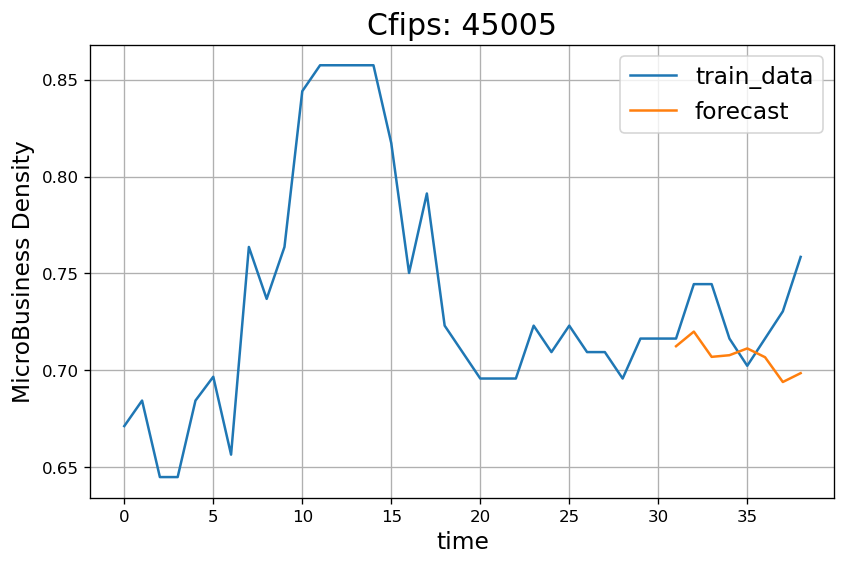

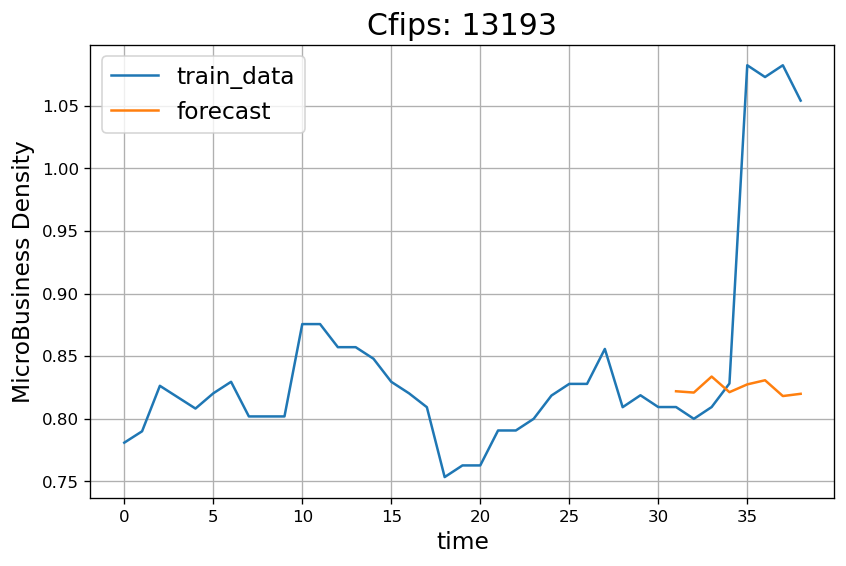

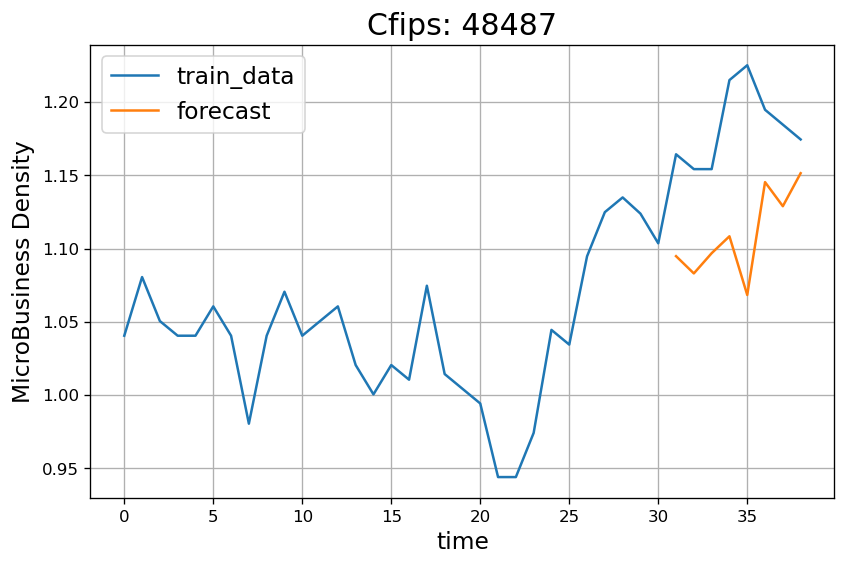

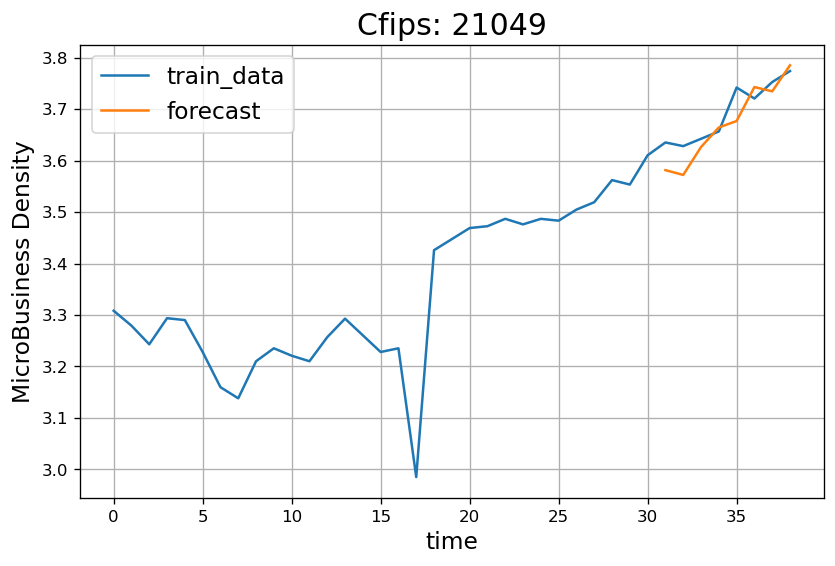

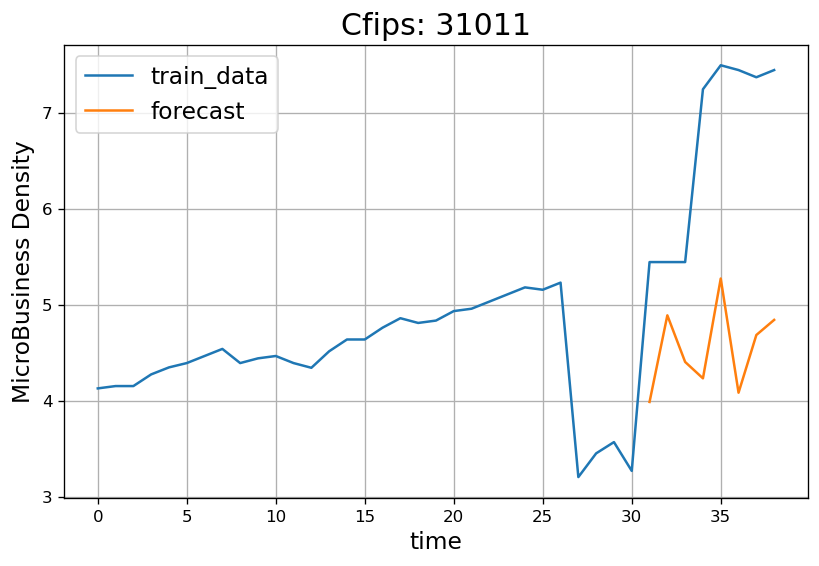

In [5]:
for idx in random.sample(list(result_df.index), 5):
    c = result_df.loc[idx].Country
    df = train[train.cfips == c]
    preds = result_df.loc[idx].forecast
    plot_time_series(c, x_train, df.microbusiness_density.values, label='train_data')
    plot_time_series(c, x_test, preds, label='forecast')
    plt.show()

In [18]:
(3*60 + 52) / 47.1

4.925690021231422

In [19]:
2*60 / 4.92

24.390243902439025

## Conclusion:

Without multiprocessing, the process for 100 countries took about 3min 52sec. It took 47.1sec with using multiprocessing, so about 5 times quicker process with multiprocessing. 

With Dense layer, the process took almost 2 hours but with multiprocessing, it should take 24 min. 

In [13]:
%%time
if __name__ == '__main__':
    HORIZON = 8
    WINDOW_SIZE = 8

    train = pd.read_csv('train.csv')
    IDS = train.cfips.unique()

    x_train = np.arange(39).reshape((-1,1))
    x_test = np.arange(31,39).reshape((-1,1))
    window_size = WINDOW_SIZE
    horizon = HORIZON
    epoch = 500
    
    cfips_list = []
    mapes = []
    density_values = []
    active_size = []
    forecasts = []

    pool = mp.Pool(16)

    func = partial(train_get_result, train, window_size, horizon, epoch)
    results = pool.map(func, IDS)
    pool.close()
    pool.join()
    
    # Create DataFrame
    for i in range(len(results)):
        c = results[i][0]
        cfips_list.append(c)
        last_density = results[i][1]
        density_values.append(last_density)
        last_active = results[i][2]
        active_size.append(last_active)
        mape = results[i][3]
        mapes.append(mape)
        preds = results[i][4]
        x = np.array(preds).reshape((-1))
        preds = x.astype(np.float64)
        forecasts.append(preds)
    
    result_df = pd.DataFrame({'Country': cfips_list,
                             'MAPE': mapes,
                             "Density": density_values,
                             'Active': active_size,
                             'forecast': forecasts})

CPU times: total: 5.67 s
Wall time: 14min 1s


In [14]:
result_df

,Country,MAPE,Density,Active,forecast
0,1001,1.417421,3.334431,1417,"[3.3108668327331543, 3.3126509189605713, 3.323..."
1,1003,4.196681,7.823300,13401,"[7.868815898895264, 7.868452072143555, 7.84069..."
2,1005,1.185098,1.206827,239,"[1.1813340187072754, 1.1708394289016724, 1.175..."
3,1007,6.075342,1.236650,220,"[1.2209161520004272, 1.1954143047332764, 1.208..."
4,1009,1.262635,1.777708,789,"[1.7684862613677979, 1.7747997045516968, 1.777..."
...,...,...,...,...,...
3130,56037,9.978364,2.892446,927,"[3.1089422702789307, 3.1881651878356934, 3.092..."
3131,56039,2.905866,25.438322,4875,"[25.509532928466797, 25.50068473815918, 25.414..."
3132,56041,13.356834,3.954258,574,"[3.575770854949951, 3.4783244132995605, 3.4778..."
3133,56043,3.020502,3.027295,183,"[3.074720621109009, 3.0981178283691406, 3.0835..."


In [15]:
result_df.to_csv("dense_results_full_data_2.csv", index=False)

I saved the resuts as dense_results_full_data.csv. It only took less than 17 munites. I will use this results for analyze then find a way to maximize MAPE>

In [16]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   3135 non-null   int64  
 1   MAPE      3135 non-null   float32
 2   Density   3135 non-null   float64
 3   Active    3135 non-null   int64  
 4   forecast  3135 non-null   object 
dtypes: float32(1), float64(1), int64(2), object(1)
memory usage: 110.3+ KB


In [17]:
type(result_df.iloc[0]['forecast'][0])

numpy.float64

In [18]:
# List of forecasts to put on pandas dataframe to numpy array the reshape it. This will make 1D array. 
len(np.array(forecasts).reshape((-1)))

25080

In [19]:
result_df.describe()

,Country,MAPE,Density,Active
count,3135.000000,3135.000000,3135.000000,3.135000e+03
mean,30376.037640,66.520531,3.918186,6.604037e+03
std,15145.862593,3417.547852,6.173361,3.353639e+04
min,1001.000000,0.287190,0.000000,0.000000e+00
25%,18178.000000,1.924506,1.658691,1.455000e+02
50%,29173.000000,3.419774,2.587083,4.890000e+02
75%,45076.000000,5.859985,4.545713,2.139500e+03
max,56045.000000,191352.734375,217.587110,1.137607e+06


In [20]:
# Next get rsult with all the same values
IDS = train.cfips.unique()
x_train = np.arange(31).reshape((-1,1))
x_test = np.arange(31,39).reshape((-1,1))

# Based on the Chris's rule, SMAPE > THRESHOLD -> Use linear regrssion 
mapes = []

for cfips in IDS:
    c = cfips
    
    df = train.loc[train['cfips'] == c]
    last = df['microbusiness_density'].values[-9]


    preds = [last]*8
    test_label = np.expand_dims(np.array(train[train['cfips'] == c]['microbusiness_density'][31:39]), axis=0)
    results = evaluate_preds(test_label, preds)
    m = results['mape']
    forecasts.append(np.array(preds).reshape((-1)))
    mapes.append(m)


result_df['SV_MAPE'] = mapes

In [21]:
result_df.describe()

,Country,MAPE,Density,Active,SV_MAPE
count,3135.000000,3135.000000,3135.000000,3.135000e+03,3135.000000
mean,30376.037640,66.520531,3.918186,6.604037e+03,3.909996
std,15145.862593,3417.547852,6.173361,3.353639e+04,21.621550
min,1001.000000,0.287190,0.000000,0.000000e+00,0.000000
25%,18178.000000,1.924506,1.658691,1.455000e+02,1.394263
50%,29173.000000,3.419774,2.587083,4.890000e+02,2.353172
75%,45076.000000,5.859985,4.545713,2.139500e+03,3.993313
max,56045.000000,191352.734375,217.587110,1.137607e+06,1183.264771


In [22]:
result_df = result_df[['Country', 'MAPE', "SV_MAPE"]]

# Compare those three numbers and categorize by the best score. 
best_scores = result_df.min(axis='columns')

In [25]:
cat = []
for i, m in enumerate(best_scores):
    if m == result_df['MAPE'].iloc[i]:
        category = 'tf_dense'
        cat.append(category)
    elif m == result_df['SV_MAPE'].iloc[i]:
        category = "SV"
        cat.append(category)
result_df['category'] = cat
result_df.head()

C:\Users\Masa\AppData\Local\Temp\ipykernel_24200\3829976995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['category'] = cat


,Country,MAPE,SV_MAPE,category
0,1001,1.417421,1.835232,tf_dense
1,1003,4.196681,5.230218,tf_dense
2,1005,1.185098,1.101416,SV
3,1007,6.075342,3.574082,SV
4,1009,1.262635,2.116541,tf_dense


In [28]:
result_df['category'].value_counts()

SV          2117
tf_dense    1018
Name: category, dtype: int64

In [30]:
result_df['best_score'] = best_scores
result_df.describe()

C:\Users\Masa\AppData\Local\Temp\ipykernel_24200\2252161307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['best_score'] = best_scores


,Country,MAPE,SV_MAPE,best_score
count,3135.000000,3135.000000,3135.000000,3135.000000
mean,30376.037640,66.520531,3.909996,3.411218
std,15145.862593,3417.547852,21.621550,19.918324
min,1001.000000,0.287190,0.000000,0.000000
25%,18178.000000,1.924506,1.394263,1.167628
50%,29173.000000,3.419774,2.353172,2.005190
75%,45076.000000,5.859985,3.993313,3.413568
max,56045.000000,191352.734375,1183.264771,1093.467163
